***
# <font color=red>Building a Forecaster using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Forecasting Demo version 23.2.0.

Copyright © 2023, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a forecaster using the Oracle AutoMLx tool for three real-world datasets. We explore the various options available in the Oracle AutoMLx Forecasting module, allowing the user to control the AutoML training process. We finally evaluate the statistical forecasting algorithms using in-built visualization tools. Note that contrary to other tasks like Classification, Regression or Anomaly detection, the AutoML package does not yet support explainability for forecasting tasks.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry exprience
  
Compatible conda pack: [Oracle AutoML and Model Explanation for Python 3.8 (version 3.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Oracle_AutoML_and_Model_Explanation_for_Python_3.8/3.0/automlx_p38_cpu_v3)

---

## Business Use

Forecasting uses historical time series data as input to make informed estimates of future trends. Learning accurate statistical forecasting model requires expertise in data science and statistics. This process typically comprises of: 
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

These steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly (faster) jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>0. Setup</a>
- <a href='#univariate'>1. Univariate time series
    - <a href='#load-m4'>1.1. Load the M4 Forecasting Competition dataset
    - <a href='#task'>1.2. Split data into train and test for the forecasting task</a>
    - <a href='#Engine'>1.3. Set the engine and deprecation warnings</a>
    - <a href='#provider'>1.4. Create an instance of Oracle AutoMLx</a>
    - <a href='#default'>1.5. Train a forecasting model using AutoMLx</a>
    - <a href='#forecast'>1.6. Generate and visualize forecasts</a>
    - <a href='#analysis'>1.7. Analyze the AutoML optimization process</a>
        - <a href='#algorithm-selection'>1.7.1 Algorithm Selection</a>
        - <a href='#hyperparameter-tuning'>1.7.2 Hyperparameter Tuning</a>
    - <a href='#load-data-air'>1.8. Load the Airline Dataset</a>
    - <a href='#scoringstr'>1.9. Specify a different score metric for optimization</a>
    - <a href='#WFCV'>1.10. Specify the number of cross-validation (CV) folds</a>
- <a href='#multi'>2. Multivariate time series</a>
    - <a href='#multi-generating'>2.1. Generate the data</a>
    - <a href='#multi-fitting'>2.2. Train a model using Oracle AutoMLx</a>
    - <a href='#multi-making'>2.3. Make predictions</a>
    - <a href='#multi-visualization'>2.4. Visualization</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
!pip install -q sktime==0.18.0

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import gzip
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init
from automl.interface.utils import plot_forecast

<a id='univariate'></a>
# Univariate time series
The Oracle AutoMLx solution for forecasting can process both univariate and multivariate time series. We start by displaying an example of use for univariate time series, and will adress multivariate data at the end of this notebook.<br> 

<a id='load-m4'></a>
### Load the M4 Forecasting Competition dataset 


We fetch a  univariate timeseries from the repository of the [M4 forecasting competition](https://mofc.unic.ac.cy/m4/).

In [3]:
m4_url = "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Train/Weekly-train.csv"
m4_metadata_url = "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv"

all_series = pd.read_csv(m4_url, index_col=0)  # consists of thousands of series
metadata_csv = pd.read_csv(m4_metadata_url, index_col=0)  # describes their datetime index

We select a series from the finance sector with weekly collection frequency. M4 dataset requires additional preprocessing to reconstruct the timeseries.

In [4]:
series_id = 'W142'
series_metadata = metadata_csv.loc[series_id]
series_values = all_series.loc[series_id]

# drop NaNs for the time period where data wasn't recorded
series_values.dropna(inplace=True)

# retrieve starting date of recording and series length to generate the datetimeindex
start_date = pd.to_datetime(series_metadata.StartingDate)
future_dates = pd.date_range(start=start_date,
                             periods=len(series_values),
                             freq='W', closed=None)
y = pd.DataFrame(series_values.to_numpy(),
                 index=future_dates,
                 columns=[(series_metadata.category+"_"+series_id)])

We can now visualize the last 200 weeks of data we have on hand.

<Axes: ylabel='Weekly Series W142'>

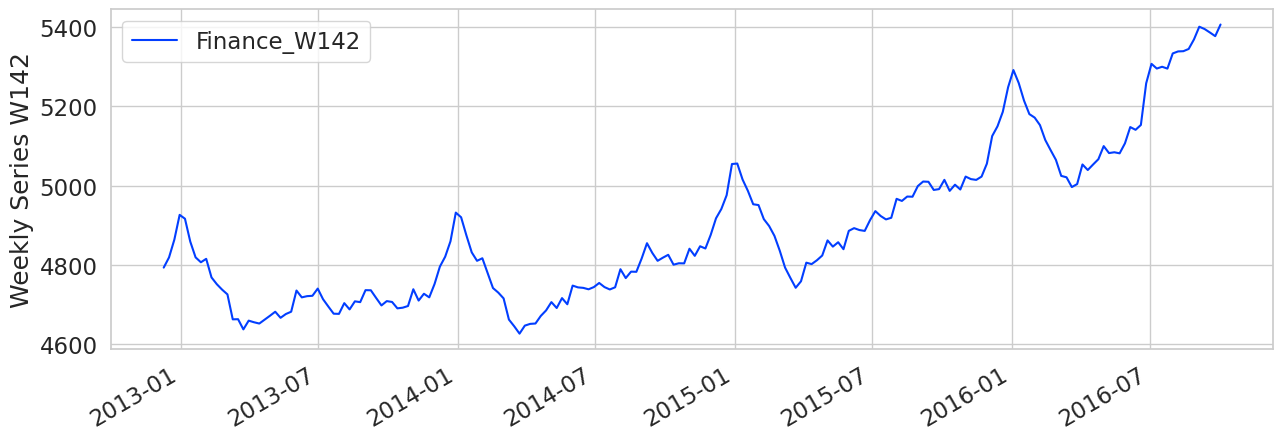

In [5]:
y = y.tail(n=200)  # approximately 4 years of data
y.plot(ylabel='Weekly Series '+series_id, grid=True)

One must ensure that the data points are in a Pandas DataFrame, sorted in chronological order.

In [6]:
print(y.index)
print("Time Index is", "" if y.index.is_monotonic else "NOT", "monotonic.")
print("Train datatype", type(y))

DatetimeIndex(['2012-12-09 12:00:00', '2012-12-16 12:00:00',
               '2012-12-23 12:00:00', '2012-12-30 12:00:00',
               '2013-01-06 12:00:00', '2013-01-13 12:00:00',
               '2013-01-20 12:00:00', '2013-01-27 12:00:00',
               '2013-02-03 12:00:00', '2013-02-10 12:00:00',
               ...
               '2016-07-31 12:00:00', '2016-08-07 12:00:00',
               '2016-08-14 12:00:00', '2016-08-21 12:00:00',
               '2016-08-28 12:00:00', '2016-09-04 12:00:00',
               '2016-09-11 12:00:00', '2016-09-18 12:00:00',
               '2016-09-25 12:00:00', '2016-10-02 12:00:00'],
              dtype='datetime64[ns]', length=200, freq='W-SUN')
Time Index is  monotonic.
Train datatype <class 'pandas.core.frame.DataFrame'>


<a id='task'></a>
### Split data into train and test for the forecasting task
As can be seen above, the data contains 200 weekly recorded values over the past 5 years. We will try to predict electricity consumption for the last 0.5 year of data (26 data points), using the previous years as training data. Hence, we separate the dataset into training and testing sets using Temporal train-test split, which ensures that the continuity of the input time series is preserved. Each point in the series represents a month, so we will hold out the last 26 points as test data.

In [7]:
y_train, y_test = temporal_train_test_split(y, test_size=26)
print("Training length: ", len(y_train)," Testing length: ", len(y_test))

Training length:  174  Testing length:  26


We see that the train data ranges from December 2012 to April 2016, while the test data ranges from April to October 2016.

In [8]:
print("y_train", y_train)
print("\ny_test", y_test)

y_train                      Finance_W142
2012-12-09 12:00:00      4793.269
2012-12-16 12:00:00      4818.969
2012-12-23 12:00:00      4863.783
2012-12-30 12:00:00      4926.357
2013-01-06 12:00:00      4916.616
...                           ...
2016-03-06 12:00:00      5024.759
2016-03-13 12:00:00      5021.153
2016-03-20 12:00:00      4996.524
2016-03-27 12:00:00      5004.032
2016-04-03 12:00:00      5053.536

[174 rows x 1 columns]

y_test                      Finance_W142
2016-04-10 12:00:00      5039.544
2016-04-17 12:00:00      5053.420
2016-04-24 12:00:00      5066.860
2016-05-01 12:00:00      5099.887
2016-05-08 12:00:00      5082.291
2016-05-15 12:00:00      5084.340
2016-05-22 12:00:00      5081.651
2016-05-29 12:00:00      5106.797
2016-06-05 12:00:00      5147.906
2016-06-12 12:00:00      5140.993
2016-06-19 12:00:00      5153.210
2016-06-26 12:00:00      5258.369
2016-07-03 12:00:00      5307.455
2016-07-10 12:00:00      5295.631
2016-07-17 12:00:00      5300.088
2016-07-

<a id='Engine'></a>
### Setting the engine and deprecation warnings
The AutoML pipeline offers the function `init`, which allows to initialize the parallelization engine. 

In [9]:
init(engine='dask')

[2023-05-29 17:39:33,993] [automl.xengine] Using Dask Execution


<automlx-23.2.0>/automl/interface/default.py:79: AutoMLxDeprecationWarning: engine dask is deprecated and will be removed in version 23.3.0.
<automlx-23.2.0>/automl/interface/default.py:82: AutoMLxDeprecationWarning: engine option dask_scheduler is deprecated and will be removed in version 23.3.0


As you can see from the above deprecation warning, dask and it's related configuration options are deprecated, and will be removed in AutoMLx version 23.3.0. This, along with a few other API changes, are coming in 23.3.0. By default, the AutoMLx package is configured to display deprecation warnings for all such changes. However, they can be disabled for any newly-created AutoMLx objects via `init`. 

We will also switch to the `'local'` parallelization engine, which uses python's multiprocessing library for parallelism instead.

In [10]:
init(engine='local', check_deprecation_warnings=False)

[2023-05-29 17:39:35,010] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
[2023-05-29 17:39:35,385] [automl.xengine] Local ProcessPool execution (n_jobs=16)


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution automatically provides a tuned forecasting pipeline that best models the given training dataset and a prediction task at hand. Here the dataset can be any univariate time-series.

AutoML for Forecasting consists of three main modules: 
- **Preprocessing**
    - Impute any missing values using back fill or forward fill mechanisms to ensure input has a well-defined and consistent frequency.
    - Identify seasonalities present in the data by detrending and analyzing the Autocorrelation Function (ACF) of the series.
    - Decide appropriate number of cross-validation (CV) folds and the forecast horizons based on the datetime frequency of data.
- **Algorithm Selection**: Identify the right algorithm for a given dataset, choosing from the following:
    - NaiveForecaster - Naive and Seasonal Naive method
    - ThetaForecaster - Equivalent to Simple Exponential Smoothing (SES) with drift
    - ExpSmoothForecaster - Holt-Winters' damped method
    - STLwESForecaster - Seasonal Trend LOESS (locally weighted smoothing) with Exponential Smoothing substructure
    - STLwARIMAForecaster - Seasonal Trend LOESS (locally weighted smoothing) with ARIMA substructure
    - SARIMAForecaster - Seasonal Autoregressive Integrated Moving Average
    - ETSForecaster - Error, Trend, Seasonality (ETS) Statespace Exponential Smoothing
    - ProphetForecaster (optional) - Facebook Prophet. Only available if installed locally with `pip install fbprophet`
    - OrbitForecaster (optional) - Uber Orbit model with Exogenous Variables. (Available if a supported version is installed)
    - VARMAXForecaster - Vector AutoRegressive Moving Average with Exogenous Variables (Available for multivariate datasets)
    - DynFactorForecaster - Dynamic Factor Models in state-space form with Exogenous Variables (Available for multivariate datasets)
- **Hyperparameter Tuning** 
    - Find the right model parameters that maximize score for the given dataset. 

These pieces are readily combined into a simple AutoML pipeline which automates the entire forecasting process with minimal user input/interaction. One can then evaluate and visualize the forecast produced by the selected model, and optionally the other tuned models.

<a id='default'></a>
### Train a forecasting model using Oracle AutoMLx

The AutoML API is quite simple to work with. We first create an instance of the pipeline. Next, the training data is passed to the `fit()` function which successively executes the previously mentioned modules.

The generated model can then be used for forecasting tasks. By default, we use the negative of symmetric mean absolute percentage error (sMAPE)  scoring metric to evaluate the model performance. The parameter `n_algos_tuned` sets the number of algorithms whose hyperparameters are fully tuned. For highest accuracy results, it is recommended to set this value to >=2 and preferably to 8 such that all models are fully tuned.

In [11]:
est1 = automl.Pipeline(task='forecasting', n_algos_tuned=4)
est1.fit(X=None, y=y_train)

print('Selected model: {}'.format(est1.selected_model_))
print('Selected model params: {}'.format(est1.selected_model_params_))

[2023-05-29 17:39:36,003] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 17:39:36,717] [automl.pipeline] Forecast horizon set to 13 for validation sets.
[2023-05-29 17:39:36,720] [automl.pipeline] Dataset shape: (174, 1)
[2023-05-29 17:39:36,733] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 17:39:36,760] [automl.preprocessing] Number of simple differencing orders required: d = 1
[2023-05-29 17:39:36,763] [automl.preprocessing] Seasonal Periodicities; from decomposed/adjusted: [52, 53, 1] ACF(54-lags):
 [ 1.     0.309  0.201  0.01   0.203  0.04  -0.16  -0.197 -0.042  0.045
 -0.389 -0.279 -0.362  0.109 -0.106 -0.083 -0.045  0.249  0.15  -0.062
 -0.073  0.001  0.217 -0.117 -0.06  -0.143  0.221 -0.038 -0.073 -0.161
  0.148  0.117 -0.055 -0.052  0.034  0.29  -0.005 -0.077 -0.191  0.071
 -0.238 -0.25  -0.34  -0.033  0.048 -0.153 -0.113 -0.04   0.192  0.064
  0.179  0.183  0.646  0.322  0.154]
[2023-05-29 17:39:36,769] [automl.pipeline] Forecasting centric

The selected model params indicate a good fit at sp (seasonal periodicity) of 52, which typically corresponds to a yearly seasonality for data that is weekly collected (i.e., there are 52 weeks in a year).

<a id='forecast'></a>
### Generating and visualizing forecasts
There are two interfaces that support generating future forecasts using the trained forecasting pipeline.
The preferred function, `forecast()`, accepts a user-input value for the number of periods to forecast into the future, i.e., relative to the end of the training series. It also accepts a significance level to generate prediction confidence intervals (CIs). When the methods support intervals, confidence intervals at 1-alpha are generated, e.g., significance level alpha=0.05 generates 95% confidence intervals.

In [12]:
summary_frame = est1.forecast(periods=len(y_test), alpha=0.05)
print(summary_frame)

                     Finance_W142  Finance_W142_ci_lower  \
2016-04-10 12:00:00   5046.482746            5022.948333   
2016-04-17 12:00:00   5060.118838            5029.848319   
2016-04-24 12:00:00   5074.184713            5038.830162   
2016-05-01 12:00:00   5108.444415            5069.032116   
2016-05-08 12:00:00   5091.139363            5047.690256   
2016-05-15 12:00:00   5106.323352            5058.893832   
2016-05-22 12:00:00   5089.677367            5038.923437   
2016-05-29 12:00:00   5131.250435            5077.576916   
2016-06-05 12:00:00   5138.107654            5081.341438   
2016-06-12 12:00:00   5137.858865            5078.012292   
2016-06-19 12:00:00   5135.514478            5073.052695   
2016-06-26 12:00:00   5158.712787            5093.832415   
2016-07-03 12:00:00   5182.740352            5115.232599   
2016-07-10 12:00:00   5174.864035            5104.775536   
2016-07-17 12:00:00   5164.800102            5092.503676   
2016-07-24 12:00:00   5164.649635       

The `predict(X)` interface supports absolute index-based forecasts, but does not support confidence intervals (CIs). It also downcasts the index to int64. 

It should be utilized only when you want to get both in-sample predictions (predictions at timestamps that are part of the training set) and out-of-sample predictions (predictions at timestamps that are not in the training set). The X variable should be an empty dataframe containing only the requested timestamps as index. Here we request 5 in-sample model fit values and 5 out-of-sample forecasts.

In [13]:
future_index = y_train.index[-5:].union(y_test.index[:5])
print(future_index)

DatetimeIndex(['2016-03-06 12:00:00', '2016-03-13 12:00:00',
               '2016-03-20 12:00:00', '2016-03-27 12:00:00',
               '2016-04-03 12:00:00', '2016-04-10 12:00:00',
               '2016-04-17 12:00:00', '2016-04-24 12:00:00',
               '2016-05-01 12:00:00', '2016-05-08 12:00:00'],
              dtype='datetime64[ns]', freq='W-SUN')


In [14]:
est1.predict(X=pd.DataFrame(index=future_index))

Finance_W142
169   5019.754771
170   4992.553904
171   4992.370574
172   5015.465113
173   5051.034323
174   5046.482746
175   5060.118838
176   5074.184713
177   5108.444415
178   5091.139363

AutoML provides a simple one-line tool to visualize forecasts and confidence intervals.

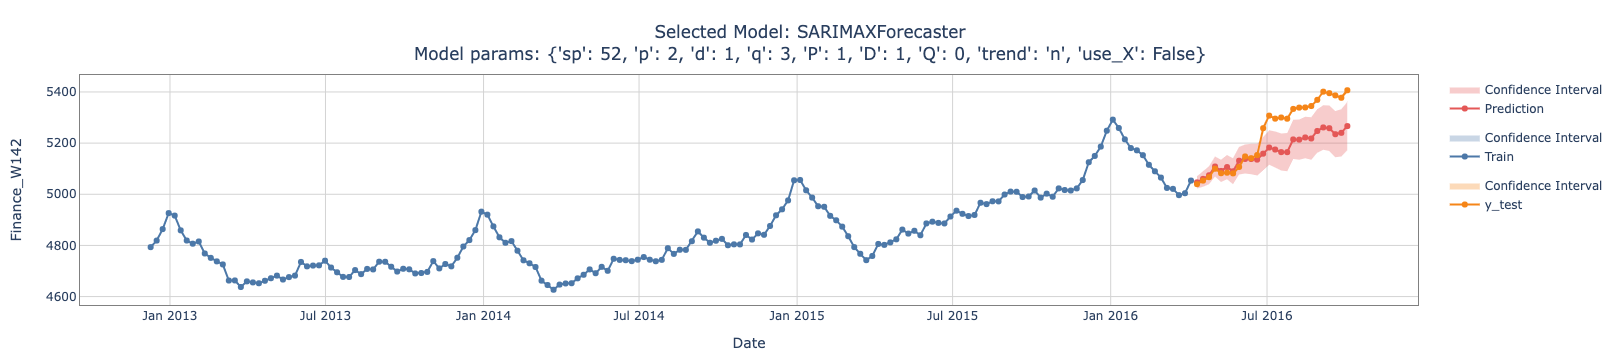

In [15]:
automl.interface.utils.plot_forecast(fitted_pipeline=est1, summary_frame=summary_frame, 
                                           additional_frames=dict(y_test=y_test)) 

<a id='analysis'></a>
### Analyze the AutoML optimization process
During the AutoML process, a summary of the optimization process is logged. It consists of:
- Information about the training data 
- Information about the AutoML Pipeline, such as:
    - selected features that AutoML found to be most predictive in the training data;
    - selected algorithm that was the best choice for this data;
    - hyperparameters for the selected algorithm.

AutoML provides a `print_summary()` API to output all the different trials performed.

In [16]:
est1.print_summary()

We also provide the capability to visualize the results of each stage of the AutoML pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. Since negative sMAPE is used by default, higher values (closer to zero) are better. The horizontal line shows the average score across all algorithms. Algorithms with better score than average are colored turquoise, whereas those with worse score than average are colored teal. Here we can see that the `SARIMAXForecaster` algorithm achieved the best predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

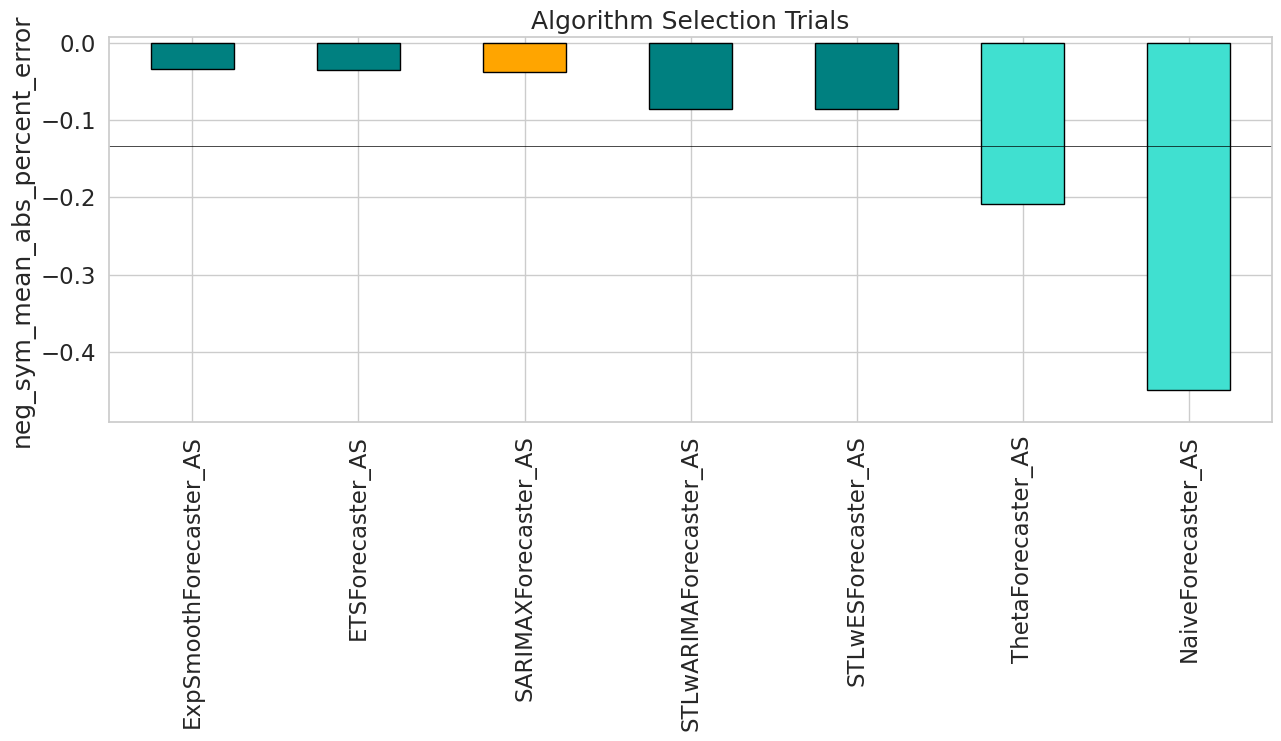

In [17]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.model_selection_trials_ 
scores = [x[3] for x in trials]
models = [x[0] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

colors = []
for f in s.keys():
    if f == '{}_AS'.format(est1.selected_model_):
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1.inferred_score_metric[0])
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter tuning is the last stage of the Oracle AutoMLx pipeline, and focuses on improving the chosen algorithm's score. We use a novel algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameter combination for the selected model.

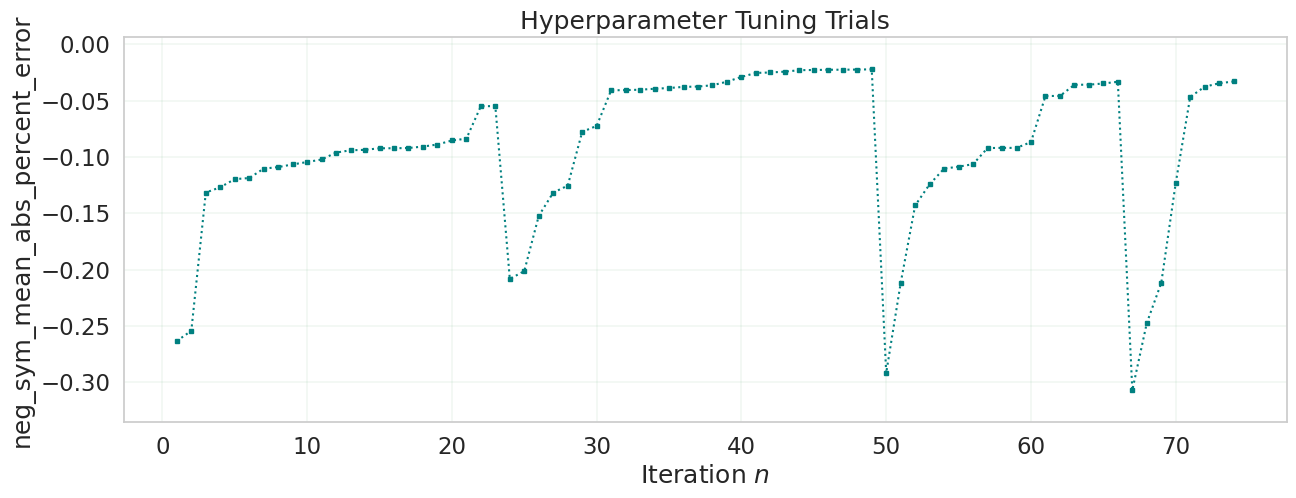

In [18]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = np.array(est1.tuning_trials_)
scores = np.array([x[3] for x in reversed(trials)])
finite_indexes = np.where(np.isfinite(scores))

trials = trials[finite_indexes]
scores = scores[finite_indexes]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

We can also view all tuned algorithms, as well as their validation and testing performance. This provides a good sanity check for the decision making.

### Plotting is enabled for total models tuned = 4.
### Model_name		 Val_score	 Test_score 
SARIMAXForecaster  	 -0.0223 	 -0.0150


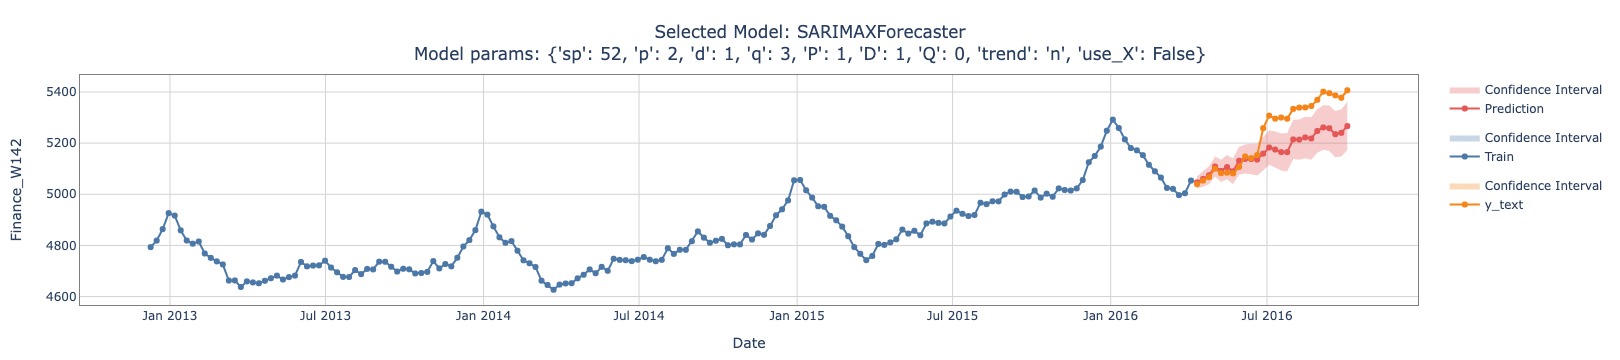

ExpSmoothForecaster  	 -0.0331 	 -0.0172


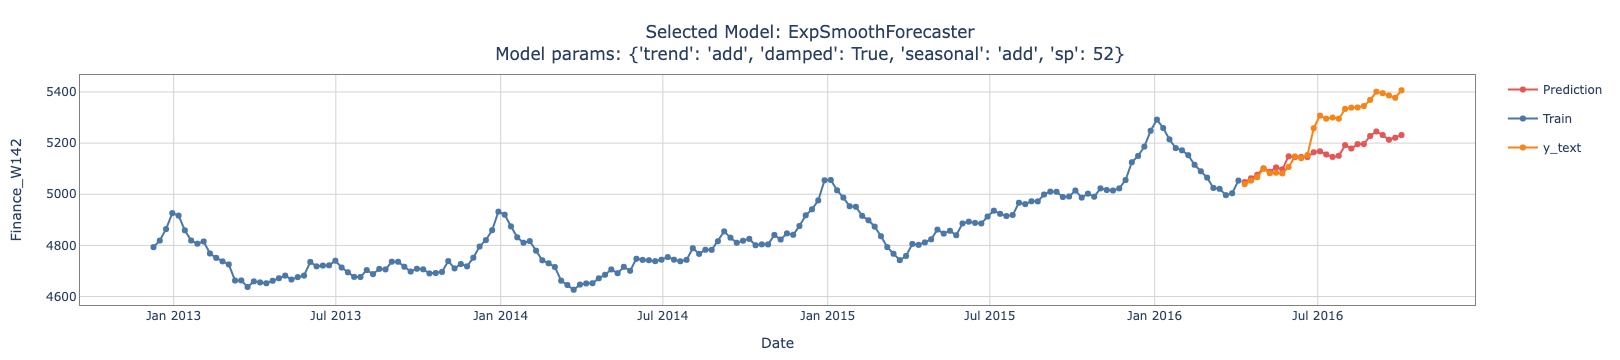

ETSForecaster  	 -0.0334 	 -0.0196


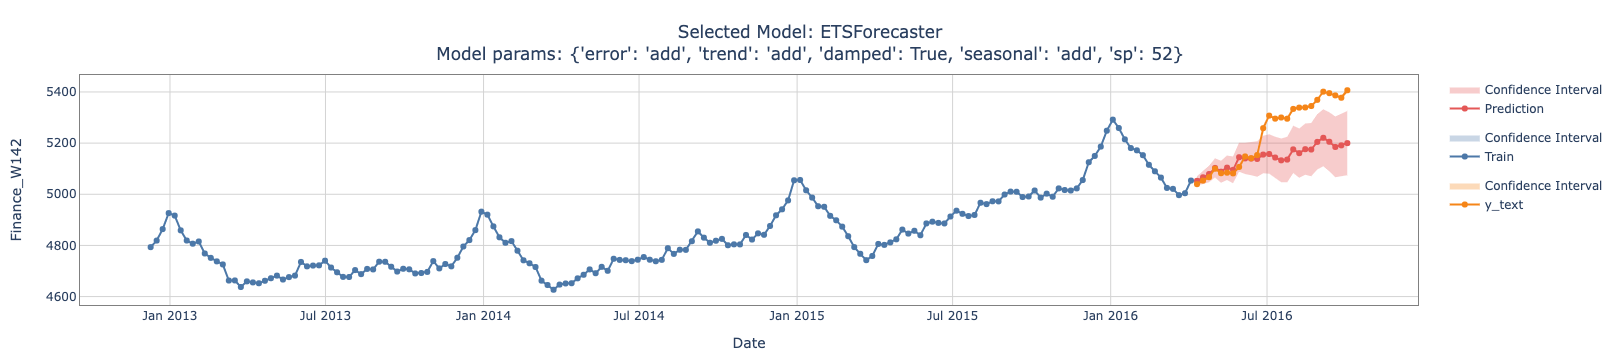

STLwARIMAForecaster  	 -0.0550 	 -0.0161


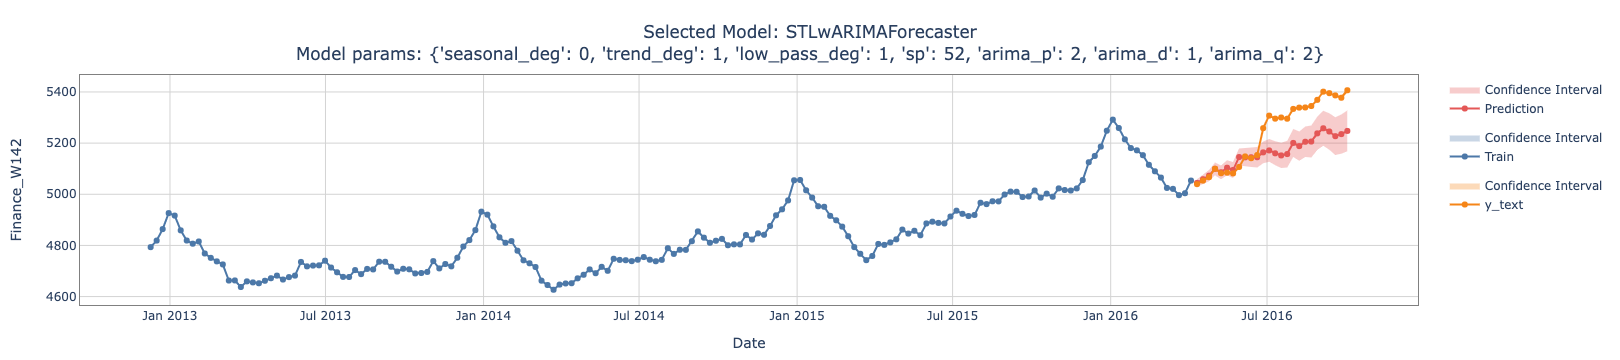

In [19]:
print(f'### Plotting is enabled for total models tuned = {len(est1.pipelines_)}.')
print('### Model_name\t\t Val_score\t Test_score ')
for i in range(0, len(est1.pipelines_)):
    pipe_ = est1.pipelines_[i]
    print(  pipe_.__dict__['selected_model_'] , " \t",
            '%.4f'%pipe_.k_results[pipe_.__dict__['selected_model_']]['best_score'],'\t',   # validation_score
            '%.4f'%pipe_.score(pd.DataFrame(index=y_test.index), y=y_test))            # testing_score
    summary_frame = pipe_.forecast(len(y_test), alpha=0.05)                     # out-of-sample forecast
    fig = automl.interface.utils.plot_forecast(fitted_pipeline=pipe_, summary_frame=summary_frame, 
                                               additional_frames=dict(y_text=y_test))
    fig.show()

<a id='load-data-air'></a>
### Load the Airline Dataset
The  Airline  Passenger univariate series represents  the  monthly  total  number  of  international airline passengers (in thousands) from January 1949 to December 1960. To showcase AutoML's functionality in the absence of a datetime index, we drop the datetime index and utilize the series with only an int64index.

<Axes: ylabel='Number of Airline Passengers'>

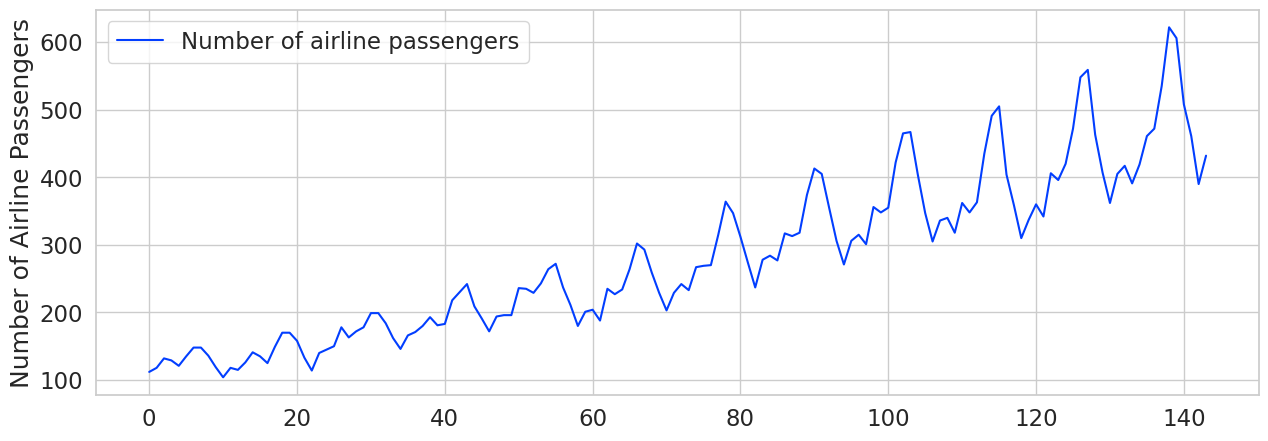

In [20]:
yair = pd.DataFrame(load_airline()) # Input must be a pd.DataFrame type
yair.index = np.arange(0, len(yair)) # replace the datetime index with an integer index.
yair.plot(ylabel='Number of Airline Passengers', grid=True)

We will forecast the last 20% of data, using the previous years as training data. 

In [21]:
yair_train, yair_test = temporal_train_test_split(yair, test_size=0.2)
print("Training length: ", len(yair_train)," Testing length: ", len(yair_test))

Training length:  115  Testing length:  29


<a id='scoringstr'></a>
### Specify a different score metric for Oracle AutoMLx optimization
The pipeline tries to maximize a given score metric, by looking at different methods and hyperparameter choices. By default, the score metric is set to negative of sMAPE. The user can also choose another metric. For the forecasting task, possible metrics are:
'neg_sym_mean_abs_percent_error', 'neg_root_mean_squared_percent_error', 'neg_mean_abs_scaled_error', 
                            'neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_max_absolute_error', 'neg_mean_absolute_error' is accepted.


Here, we ask AutoML to optimize for MASE ('neg_mean_abs_scaled_error'), a scale-invariant scoring metric.

In [22]:
est2 = automl.Pipeline(task='forecasting', n_algos_tuned=3, score_metric='neg_mean_abs_scaled_error')
est2.fit(y=yair_train)

test_score = automl.models.score.time_series_loss(est2, X=pd.DataFrame(index=yair_test.index), 
                                                  y=yair_test, scoring='neg_mean_abs_scaled_error')
print('Selected model: {}'.format(est2.selected_model_))
print('Selected model params: {}'.format(est2.selected_model_params_))
print(f'Score on test data : {test_score}')

[2023-05-29 17:43:28,229] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 17:43:28,838] [automl.pipeline] Dataset shape: (115, 1)
[2023-05-29 17:43:28,850] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 17:43:28,869] [automl.preprocessing] Number of simple differencing orders required: d = 2
[2023-05-29 17:43:28,871] [automl.preprocessing] Seasonal Periodicities; from decomposed/adjusted: [12, 24, 1] ACF(54-lags):
 [ 1.     0.272 -0.127 -0.121 -0.279 -0.097  0.019 -0.135 -0.346 -0.196
 -0.172  0.232  0.799  0.231 -0.118 -0.055 -0.218 -0.054  0.029 -0.124
 -0.289 -0.174 -0.14   0.204  0.643  0.181 -0.11  -0.04  -0.156 -0.028
  0.019 -0.117 -0.235 -0.156 -0.093  0.158  0.53   0.135 -0.094 -0.025
 -0.091 -0.012 -0.002 -0.091 -0.214 -0.127 -0.052  0.116  0.427  0.103
 -0.097 -0.011 -0.036  0.003  0.005]
[2023-05-29 17:43:28,875] [automl.pipeline] Forecasting centric preprocessing completed. Updated Dataset shape: (115, 1), cv: [(55, 30), (85, 30)]
[2023-05

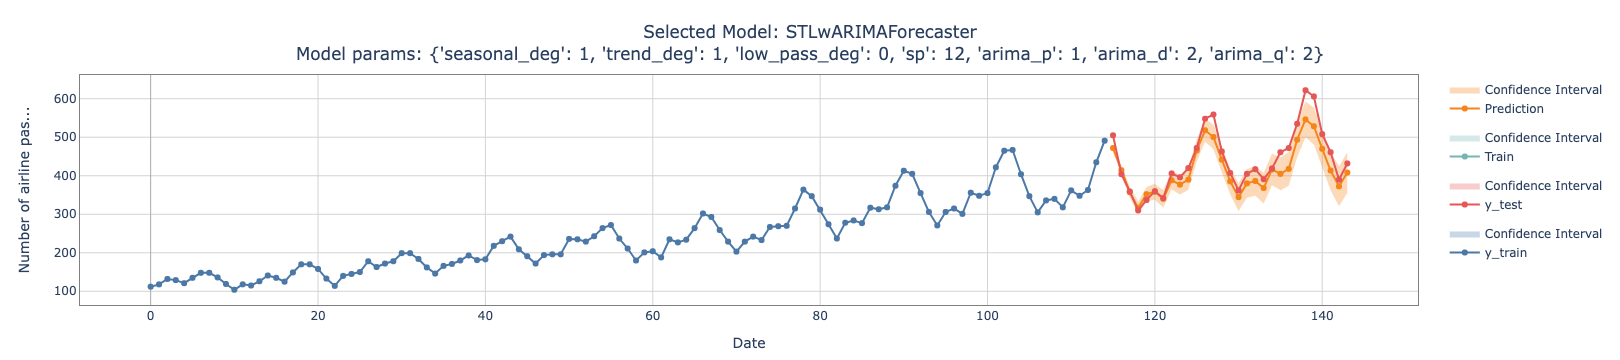

In [23]:
automl.interface.utils.plot_forecast(fitted_pipeline=est2, summary_frame=est2.forecast(len(yair_test)), 
                                           additional_frames=dict(y_test=yair_test, y_train=yair_train))

<a id='WFCV'></a>
### Specify the number of cross-validation (CV) folds
AutoML automatically decides how many folds to create, given the length of the input series. This is dependent on the frequency and length of the series. 
In the above, the preprocessor chose to create two folds. In the following we set the number of folds to 8.

In [24]:
est3 = automl.Pipeline(task='forecasting')
est3.fit(y=yair_train, cv=8)

print('Selected model: {}'.format(est3.selected_model_))
print('Selected model params: {}'.format(est3.selected_model_params_))
print(f'Score on test data : {est3.score(pd.DataFrame(index=yair_test.index), y=yair_test)}')

fig = automl.interface.utils.plot_forecast(fitted_pipeline=est3, summary_frame=est3.forecast(len(yair_test)), 
                                           additional_frames=dict(y_test=yair_test))

[2023-05-29 17:43:55,545] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 17:43:56,199] [automl.pipeline] Dataset shape: (115, 1)
[2023-05-29 17:43:56,212] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 17:43:56,230] [automl.preprocessing] Number of simple differencing orders required: d = 2
[2023-05-29 17:43:56,233] [automl.preprocessing] Seasonal Periodicities; from decomposed/adjusted: [12, 24, 1] ACF(54-lags):
 [ 1.     0.272 -0.127 -0.121 -0.279 -0.097  0.019 -0.135 -0.346 -0.196
 -0.172  0.232  0.799  0.231 -0.118 -0.055 -0.218 -0.054  0.029 -0.124
 -0.289 -0.174 -0.14   0.204  0.643  0.181 -0.11  -0.04  -0.156 -0.028
  0.019 -0.117 -0.235 -0.156 -0.093  0.158  0.53   0.135 -0.094 -0.025
 -0.091 -0.012 -0.002 -0.091 -0.214 -0.127 -0.052  0.116  0.427  0.103
 -0.097 -0.011 -0.036  0.003  0.005]
[2023-05-29 17:43:56,237] [automl.pipeline] Forecasting centric preprocessing completed. Updated Dataset shape: (115, 1), cv: 8
[2023-05-29 17:43:56,253] [

<a id='multi'></a>
## Multivariate time series

<a id='multi-generating'></a>
### Generate the data

We now display the use of the Oracle AutoMLx solution for multivariate timeseries. We load the 10-dimensional Lutkepohl2 dataset. We then restrict the data to 4 variables : two exogenous variables (variables that are independent on all other data variables), and two endogenous variables (variables that are dependent on some other data variables). The endogenous variables will be the target predictions of the pipeline, while the exogenous variables will be used solely as explanatory variables. 

In [25]:
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc',]]
exog = dta.loc['1960-04-01':'1978-10-01', ['dln_consump']]
exog = sm.add_constant(exog)

We then split it using a temporal train-test split as done previously. Note that $X$ consists of the exogenous variables ('dln_consump' and another constant variable) while $y$ are the target variables ('dln_in' and 'dln_inc')

In [26]:
X_train_df, X_test_df = temporal_train_test_split(exog, train_size=0.9)
y_train_df, y_test_df = temporal_train_test_split(endog, train_size=0.9)

<a id='multi-fitting'></a>
### Train a model using Oracle AutoMLx

We can now fit the AutoML pipeline. For the multivariate forecasting task, the pipeline only considers two models : `VARMAX` and `DynFactor`.

In [27]:
pipeline = automl.Pipeline(task='forecasting',
                           n_algos_tuned=1,
                           score_metric='neg_sym_mean_abs_percent_error')

pipeline.fit(X=X_train_df, y=y_train_df)

[2023-05-29 17:44:11,695] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 17:44:12,303] [automl.pipeline] Forecast horizon set to 8 for validation sets.
[2023-05-29 17:44:12,305] [automl.pipeline] Dataset shape: (67, 2)
[2023-05-29 17:44:12,317] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 17:44:12,336] [automl.preprocessing] Number of simple differencing orders required: d = 1
[2023-05-29 17:44:12,338] [automl.preprocessing] Seasonal effects not found. Using datetime periodicity of 4
[2023-05-29 17:44:12,340] [automl.preprocessing] Seasonal Periodicities; from decomposed/adjusted: [4, 1] ACF(54-lags):
 [ 1.    -0.568  0.015 -0.015  0.25  -0.265  0.047  0.149 -0.095 -0.109
  0.092  0.143 -0.203  0.012  0.113 -0.026 -0.177  0.165  0.116 -0.274
  0.119  0.074 -0.051 -0.079  0.087  0.042 -0.175  0.113  0.063 -0.074
 -0.042  0.111 -0.068 -0.026  0.048  0.09  -0.198  0.112 -0.014  0.097
 -0.169  0.097 -0.039  0.055 -0.085  0.068 -0.016 -0.037  0.035 -0.00

Pipeline(model_list=['NaiveForecaster', 'ThetaForecaster',
                     'ExpSmoothForecaster', 'ETSForecaster', 'STLwESForecaster',
                     'STLwARIMAForecaster', 'SARIMAXForecaster',
                     'VARMAXForecaster', 'DynFactorForecaster',
                     'ProphetForecaster'])

The AutoML pipeline provides attributes to get the selected features, the chosen model, hyperparameters as well as the score on the test set.

In [28]:
print('Selected features: {}'.format(pipeline.selected_features_))
print('Ranked models: {}'.format(pipeline.ranked_models_))
print('Selected model: {}'.format(pipeline.selected_model_))
print('Selected model params: {}'.format(pipeline.selected_model_params_))

Selected features: [0, 1, 2]
Ranked models: ['VARMAXForecaster']
Selected model: VARMAXForecaster
Selected model params: {'pq_order': '40', 'trend': 'c', 'error_cov_type': 'unstructured', 'use_X': False}


<a id='multi-making'></a>
### Make predictions

As mention in the univariate data case, there are two ways of making a prediction : 
- `forecast(k)` allows one to predict k steps after the end of the training data. It should be used when one wants to make out-of-sample predictions
- `predict(X)` returns predictions at the timestamps given as argument. It should be used when one wants to make in-sample predictions and out-of-sample predictions. It does not support confidence intervals.

In the cell below `predict()` is used on the last 5 timestamps of the train set, and all timestamps of the test set. `forecast()` is used to predict k steps after the training set, where k is the size of the test set.

In [29]:
y_pred = pipeline.predict(pd.concat([X_train_df[-5:0],X_test_df], axis=0) )
y_forecast = pipeline.forecast(len(y_test_df), alpha=0.8, X=X_test_df)    # out-of-sample forecast

The obtained forecast contains predictions for the two target variables, as well as lower and upper confidence intervals, for each timestamp in the test set.

In [30]:
y_forecast

dln_inv   dln_inc  dln_inv_ci_lower  dln_inv_ci_upper
1977-01-01  0.013637  0.021205          0.002588          0.024686
1977-04-01  0.020282  0.022736          0.008766          0.031797
1977-07-01  0.007802  0.020105         -0.003724          0.019328
1977-10-01  0.031891  0.021881          0.020207          0.043574
1978-01-01  0.014414  0.021965          0.002362          0.026466
1978-04-01  0.017645  0.021431          0.005427          0.029863
1978-07-01  0.017818  0.021707          0.005579          0.030057
1978-10-01  0.022726  0.021450          0.010445          0.035006

One can also directly compute the score of the tuned model on the test set, without needing to run `forecast()` or `predict()`.

In [31]:
print("Tuned model testing score (negative sMAE): ", pipeline.score(X=X_test_df, y=y_test_df))

Tuned model testing score (negative sMAE):  -0.5925196892927673


<a id='multi-visualization'></a>
### Visualization

Finally, when given as input the forecasted variables, the `plot_forecast()` method displays an interactive plot of the predictions (for each target variable) and confidence intervals.

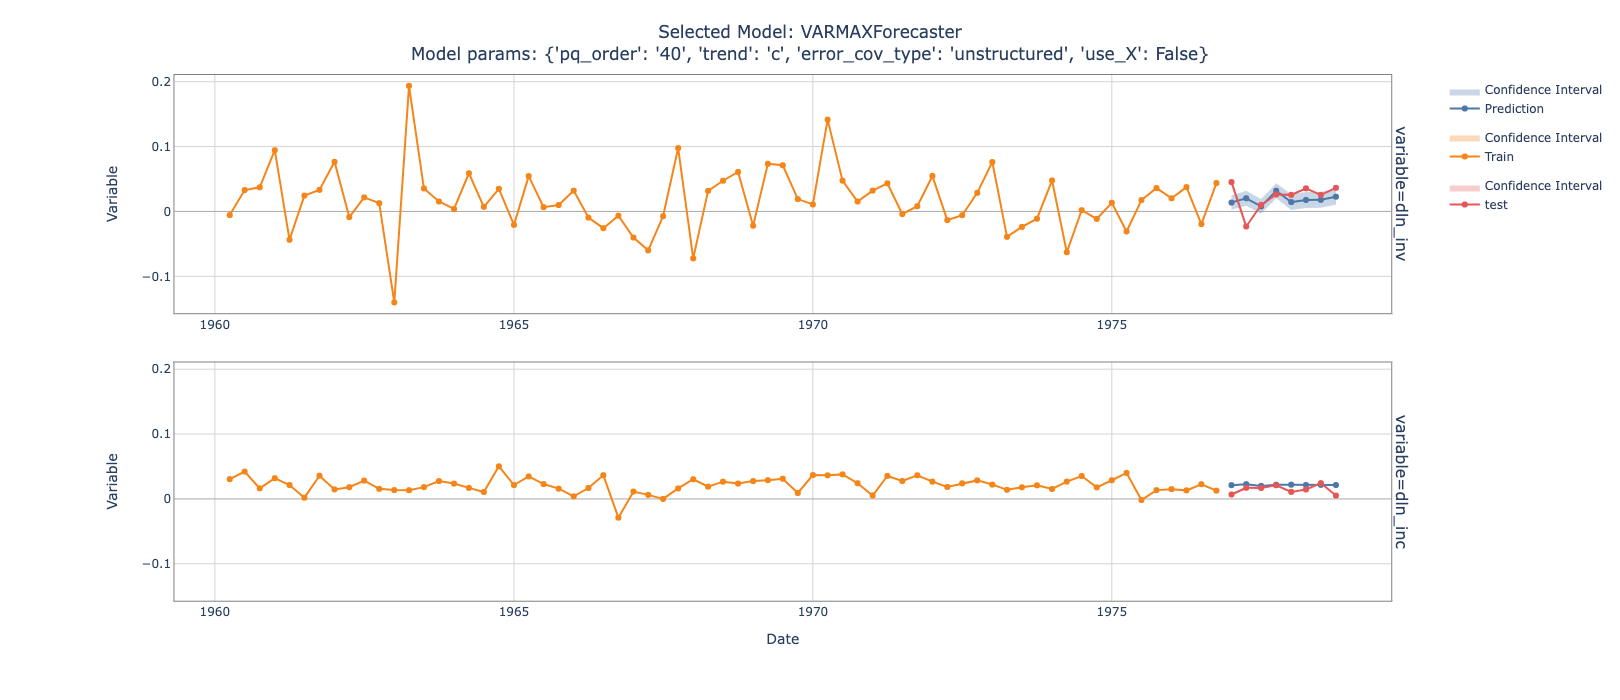

In [32]:
plot_forecast(fitted_pipeline=pipeline, summary_frame=y_forecast, additional_frames=dict(test=y_test_df))

<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoML: http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* sktime: https://www.sktime.org/en/latest/
* statsmodels: https://www.statsmodels.org/stable/index.html
* M4 Competition: https://mofc.unic.ac.cy/m4/
* Airline Dataset: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.datasets.load_airline.html
